# Visualize Notebook

In [2]:
%matplotlib inline
from new_methods.new_methods import My_NuScenes
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pythreejs as pjs

nusc = My_NuScenes(version='v1.0-mini', dataroot='/data/datasets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 3.399 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


# Min_Max_Avg Graph

In [2]:
boundary = 3

In [3]:
total_dis = {'idx': [], 'max':[], 'min':[], 'avg':[]}

for i in tqdm(range(len(nusc.sample))):
    _, diff, _ = nusc.check_depth(nusc.sample[i]['token'], boundary=boundary)
    if len(diff)!=0:
        max = np.max(diff)
        min = np.min(diff)
        avg = np.sum(diff)/len(diff)
        total_dis['idx'].append(i)
        total_dis['max'].append(max)
        total_dis['min'].append(min)
        total_dis['avg'].append(avg)

100%|███████████████████████| 404/404 [00:24<00:00, 16.26it/s]


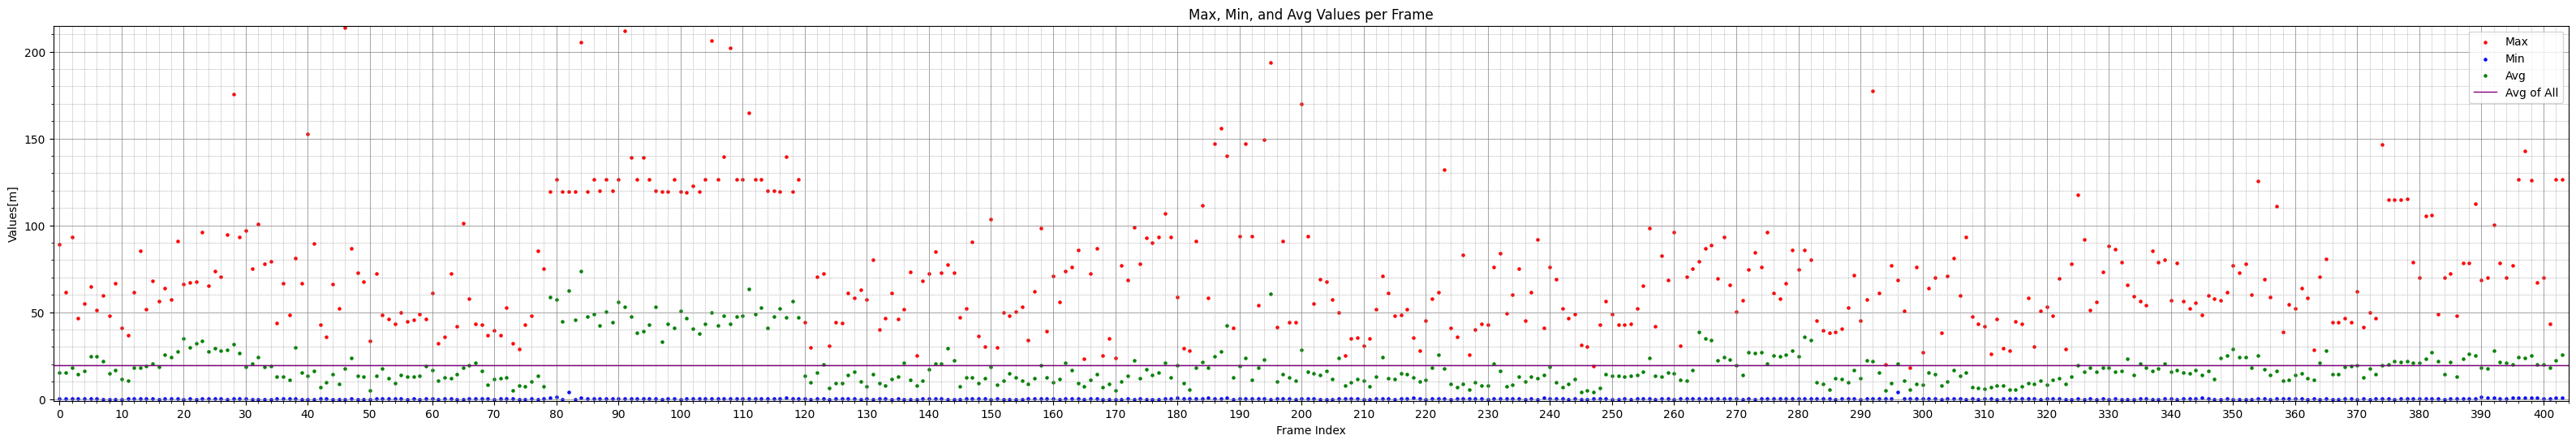

In [4]:
# 저장경로 설정
boundary_path = 'boundary_'+str(boundary)
base_path = '/home/byounghun/workspace/Nuscenes_tutorial/visualization/Graphs/'
if not osp.exists(base_path):
    os.makedirs(base_path)
file_name = 'Max_Min_Avg.png'
out_path = osp.join(base_path,boundary_path,file_name)

# total_dis에서 값 받아오기
idx = total_dis['idx']
max_values = total_dis['max']
min_values = total_dis['min']
avg_values = total_dis['avg']

avg_of_all = np.sum(avg_values)/len(avg_values)

# fig 생성
plt.figure(figsize=(40, 6))

# scatter
plt.scatter(idx, max_values, color='red', s=5, label='Max')  # Max 값은 빨간색
plt.scatter(idx, min_values, color='blue', s=5, label='Min')  # Min 값은 파란색
plt.scatter(idx, avg_values, color='green', s=5, label='Avg')  # Avg 값은 초록색
plt.axhline(y=avg_of_all, color='purple', linestyle='-', linewidth=1, label='Avg of All')

plt.title('Max, Min, and Avg Values per Frame')
plt.xlabel('Frame Index')
plt.xlim([np.min(idx)-1, np.max(idx)+1])
plt.ylabel('Values[m]')
plt.ylim([np.min(min_values)-1, np.max(max_values)+1])

plt.legend()

plt.grid(True)
plt.minorticks_on()

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')  # 주 눈금에 대한 그리드
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')  # 보조 눈금에 대한 그리드

plt.xticks(np.arange(np.min(idx), np.max(idx)+1, 10))  # x축 눈금 간격 설정
plt.yticks(np.arange(np.min(min_values), np.max(max_values)+1, 50))  # y축 눈금 간격 설정

plt.savefig(out_path)

plt.show()

# Distribution of radar depth graph

In [137]:
boundary = 3
max_range = 200
index = 83

100%|███████████████████████| 404/404 [02:13<00:00,  3.04it/s]


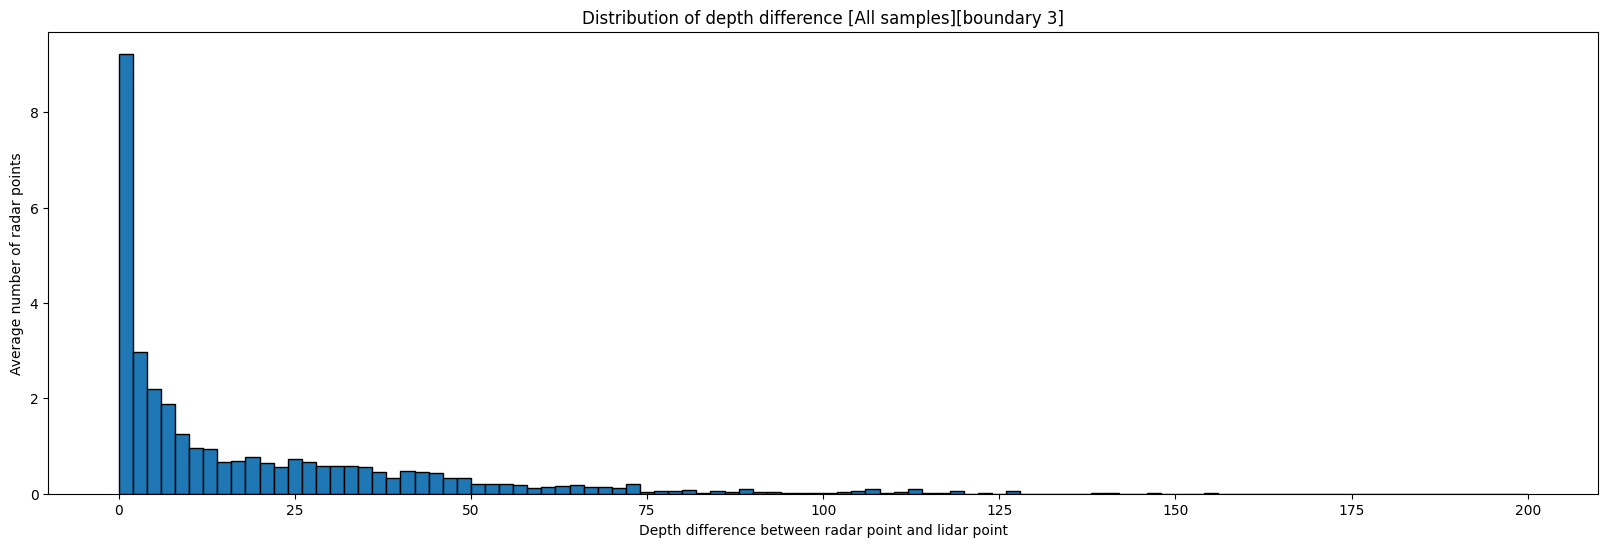

total number of radar pointclouds in 404 samples:  86928
total number of radar pointclouds who has near lidar pointcloud:  13054
total number of radar pointclouds who has no near lidar pointclouds:  73874


In [130]:
total_dis = []
total_diff = []
total_no_pts = 0
boundary_path = 'boundary_'+str(boundary)
base_path = '/home/byounghun/workspace/Nuscenes_tutorial/visualization/Graphs/'
file_name = 'Total_samples.png'

for i in tqdm(range(len(nusc.sample))):
    dis, diff, no_pts = nusc.check_depth(nusc.sample[i]['token'], boundary=boundary)
    total_dis.extend(dis)
    total_diff.extend(diff)
    total_no_pts += no_pts


bins = 100
hist_t, bin_edges_t = np.histogram(total_diff, bins=bins, range=(0,max_range))#, density=True)
hist_t = hist_t / len(nusc.sample)

plt.figure(figsize=(20, 6))
bar_centers = bin_edges_t[:-1] + np.diff(bin_edges_t) / 2
plt.bar(bar_centers, hist_t, width=np.diff(bin_edges_t), edgecolor='black')

plt.xlabel('Depth difference between radar point and lidar point')
plt.ylabel('Average number of radar points')
# plt.ylim(0,20)
# plt.yticks(np.arange(0,21,1))
plt.title('Distribution of depth difference '+'[All samples]' + '[boundary '+ str(boundary) + ']')

out_path = osp.join(base_path,boundary_path,file_name)
# plt.savefig(out_path)
plt.show()
print('total number of radar pointclouds in 404 samples: ', str(len(total_diff)+total_no_pts))
print('total number of radar pointclouds who has near lidar pointcloud: ', str(len(total_diff)))
print('total number of radar pointclouds who has no near lidar pointclouds: ', str(total_no_pts))

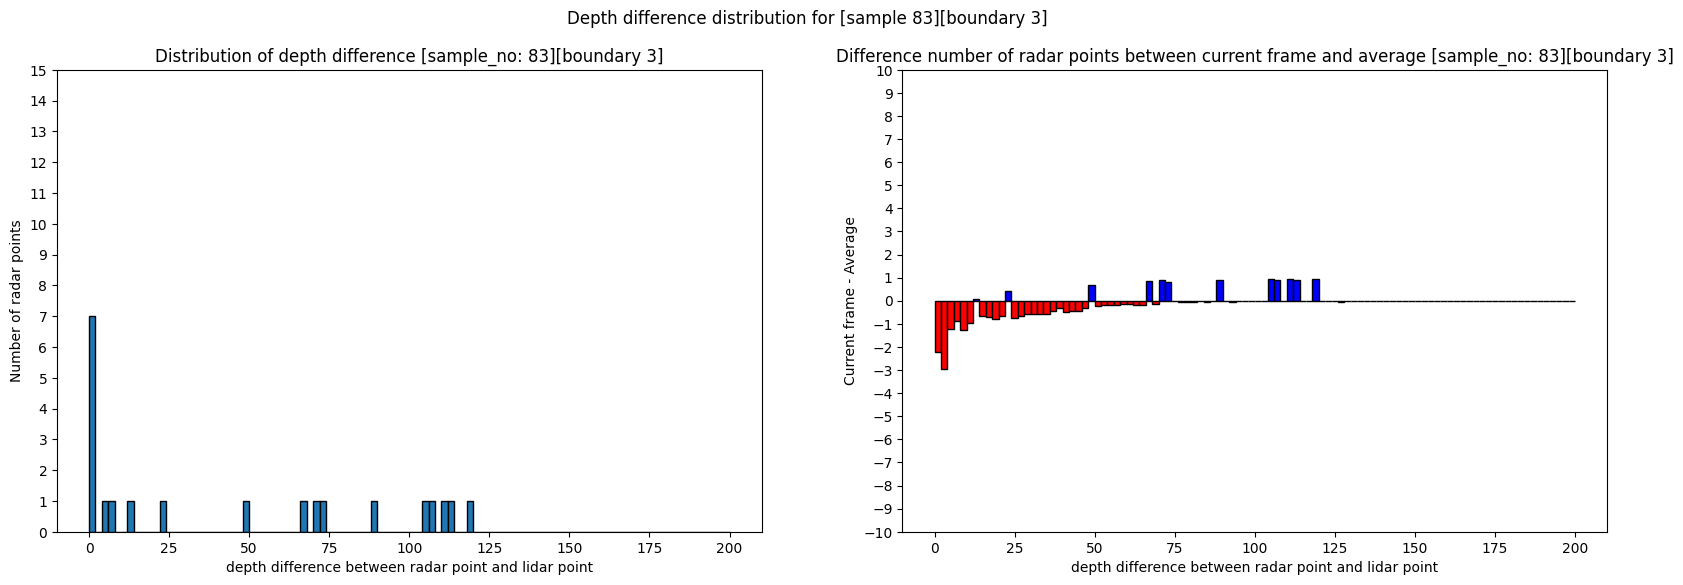

In [139]:
dis, diff, no_pts = nusc.check_depth(nusc.sample[index]['token'], boundary=boundary)
hist, bin_edges = np.histogram(diff, bins=bins, range=(0,max_range))#, density=True)
proportion_difference = hist - hist_t

colors = ['red' if value < 0 else 'blue' for value in proportion_difference]

file_name = 'sample_'+str(index)+'.png'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
bar_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
axes[0].bar(bar_centers, hist, width=np.diff(bin_edges), edgecolor='black')
axes[0].set_xlabel('depth difference between radar point and lidar point')
axes[0].set_ylabel('Number of radar points')
axes[0].set_ylim(0,15)
axes[0].set_yticks(np.arange(0,16,1))
axes[0].set_title('Distribution of depth difference '+'[sample_no: '+ str(index) + ']'+'[boundary '+ str(boundary) + ']')

axes[1].bar(bar_centers, proportion_difference, color=colors, width=(max_range/bins), edgecolor='black')
axes[1].set_xlabel('depth difference between radar point and lidar point')
axes[1].set_ylabel('Current frame - Average')
axes[1].set_ylim(-10,10)
axes[1].set_yticks(np.arange(-10,11,1))
axes[1].set_title('Difference number of radar points between current frame and average '+'[sample_no: '+ str(index) + ']'+'[boundary '+ str(boundary) + ']')

fig.suptitle('Depth difference distribution for [sample '+str(index)+']'+'[boundary '+ str(boundary) + ']')

out_path = osp.join(base_path,boundary_path,file_name)
plt.tight_layout
plt.show()
# plt.savefig(out_path)
# plt.close()

# Visualize

In [165]:
index = 83
nsweeps = 5

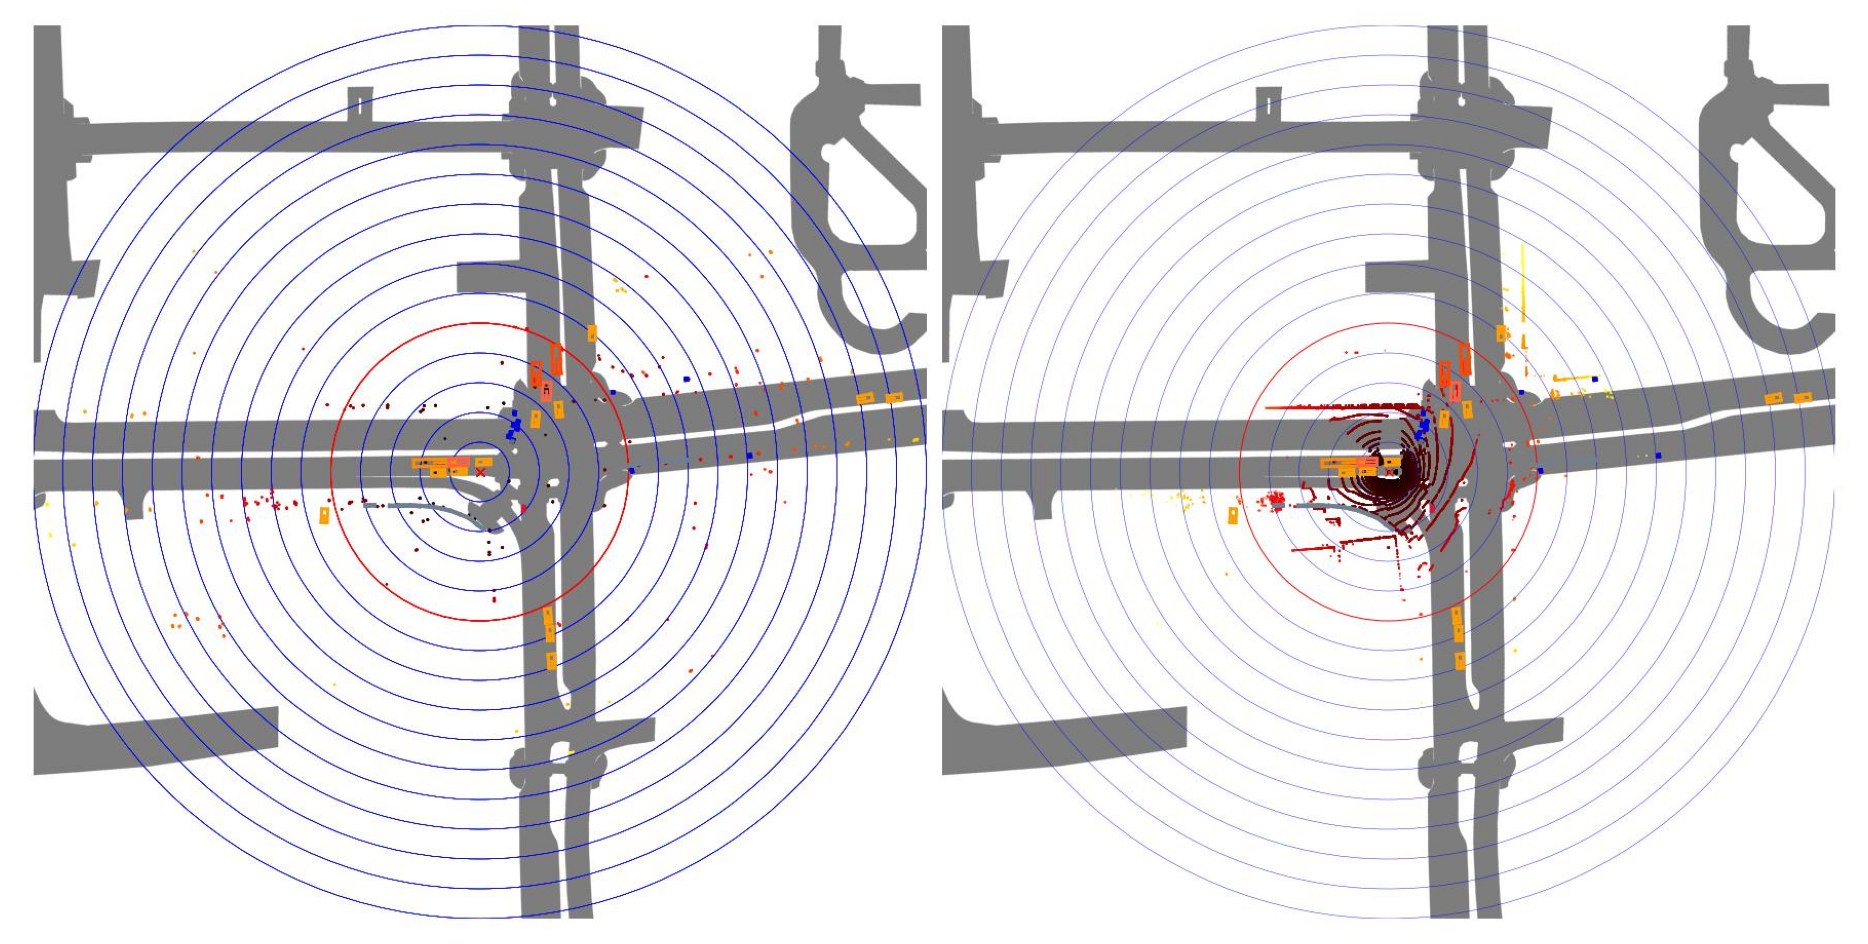

In [166]:
nusc.render_sample_new(nusc.sample[index]['token'], nsweeps=nsweeps,
                       out_path='/home/byounghun/workspace/sample_bev.jpg',
                       sample_path='/home/byounghun/workspace/sample.jpg',
                       verbose = True)

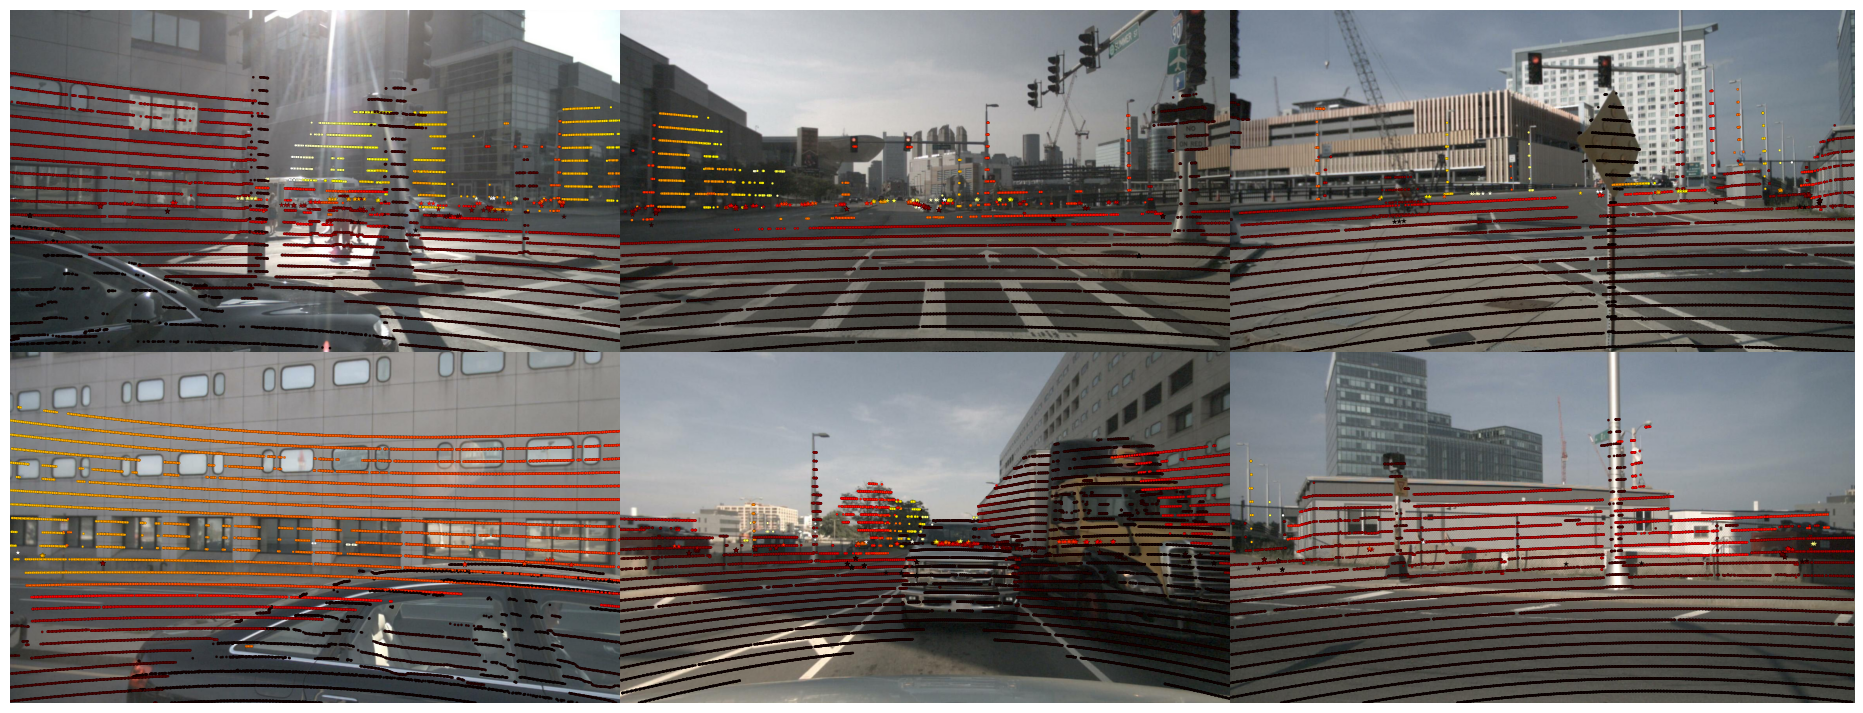

In [167]:
nusc.render_pointcloud_in_scene(nusc.sample[index]['token'], nsweeps = nsweeps, show_both_modality=True, verbose=True)

In [168]:
def visualize_3d(index=0, nsweeps=1, rgb_radar=[1,0,0], rgb_lidar=[0,0,1],
                 size_radar=1, size_lidar=0.1, height=800, width=800):
    # pts
    radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    lidar_pc = nusc.make_points_list('l', index, nsweeps=nsweeps).astype(np.float32)

    # radar pc
    radar_points_buf = pjs.BufferAttribute(array=radar_pc)
    radar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_radar] * len(radar_pc), dtype=np.float32))
    radar_geometry = pjs.BufferGeometry(attributes={'position': radar_points_buf, 'color': radar_colors_buf})
    radar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_radar)
    radar_pointCloud = pjs.Points(geometry=radar_geometry, material=radar_material)

    # lidar pc
    lidar_points_buf = pjs.BufferAttribute(array=lidar_pc)
    lidar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_lidar] * len(lidar_pc), dtype=np.float32))
    lidar_geometry = pjs.BufferGeometry(attributes={'position': lidar_points_buf, 'color': lidar_colors_buf})
    lidar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_lidar)
    lidar_pointCloud = pjs.Points(geometry=lidar_geometry, material=lidar_material)

    pythreejs_camera = pjs.PerspectiveCamera(up=[1, 0, 1], children=[pjs.DirectionalLight(color='black', intensity=0.5)])
    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)
    
    scene = pjs.Scene(children=[radar_pointCloud, lidar_pointCloud, pythreejs_camera, pjs.AmbientLight(color='#777777')])
    axes = pjs.AxesHelper(size=3)
    scene.add(axes)
        
    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera, scene=scene, width=width, height=height, preserveDrawingBuffer=True, controls=[control])
    
    return renderer


In [169]:
renderer = visualize_3d(index=index, nsweeps=nsweeps, size_radar=0.5, size_lidar=0.1)
renderer

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='black', intensity=0.5, position=(0.0, 0.0,…

# Find index of validation dataset

In [3]:
import pickle

with open('/home/byounghun/workspace/CRN/data/nuScenes/nuscenes_infos_val.pkl', 'rb') as f:
	data = pickle.load(f)

val_sample_list = [d['sample_token'] for d in data]
print(len(val_sample_list))
val_sample_list

6019


['fd8420396768425eabec9bdddf7e64b6',
 '6eb8a3ff0abf4f3a9380a48f2a0b87ef',
 'b10f0cd792b64d16a1a5e8349b20504c',
 '163b70e627854893b88575caf85a56ea',
 'f56a544064a548a39a81f18cc8f633c5',
 'f286cdaef36648cba3b6a24d2178dc8a',
 '877f55a6d8324fefb5e0f5e0bac3d7c1',
 '49f8376cd6b34f07b20ed6d5b5b42acd',
 'cc50000970584ba5aaf14760b1ced696',
 '21b99febc5c14f7385e787fe81e96670',
 'cd908fdce67249f3a8a14b987f00592e',
 '6b9af38cbf654171870cb14b4ae89fd6',
 'a0edf6edd121431785948038c54e036e',
 '9281ea172d9e43528e65fca81e2006d4',
 '6180726fc8744ea2b129ebaad6f79cee',
 '1ac0914c98b8488cb3521efeba354496',
 '2f5de0aeca704127925cf8490ff5a21d',
 'e4df3ac5874d49b7a3553035cd735902',
 'dc878ebb5b1e43eb9442d9361854613e',
 'e617edf72860495abd928aaf57dfa5fa',
 '7c0aa537b98344bea85226ba8148ae98',
 '02651ca22b08484294d473d9c26cd9af',
 '37b3d16060b442d5b6175cbebefd09a7',
 '9c75ddb5976343c3b7b33e8148d3eeb0',
 '5e4e25f87ec84942ac459a55fe064330',
 'c1ab33c3994041ceae32b0fe1b51e611',
 '23dc1b528c734082b8b3bfd9757f0eb3',
 

In [4]:
mini_sample_token_list = [sample['token'] for sample in nusc.sample]
idx_dict = {}

for mini_sample in mini_sample_token_list:
    if mini_sample in val_sample_list:
        idx = val_sample_list.index(mini_sample)
        idx_mini = mini_sample_token_list.index(mini_sample)
        idx_dict[idx_mini] = idx
print(len(idx_dict))
idx_dict

162


{39: 914,
 40: 915,
 41: 916,
 42: 917,
 43: 918,
 44: 919,
 45: 920,
 46: 921,
 47: 922,
 48: 923,
 49: 924,
 50: 925,
 51: 926,
 52: 927,
 53: 928,
 54: 929,
 55: 930,
 56: 931,
 57: 932,
 58: 933,
 59: 934,
 60: 935,
 61: 936,
 62: 937,
 63: 938,
 64: 939,
 65: 940,
 66: 941,
 67: 942,
 68: 943,
 69: 944,
 70: 945,
 71: 946,
 72: 947,
 73: 948,
 74: 949,
 75: 950,
 76: 951,
 77: 952,
 78: 953,
 79: 2266,
 80: 2267,
 81: 2268,
 82: 2269,
 83: 2270,
 84: 2271,
 85: 2272,
 86: 2273,
 87: 2274,
 88: 2275,
 89: 2276,
 90: 2277,
 91: 2278,
 92: 2279,
 93: 2280,
 94: 2281,
 95: 2282,
 96: 2283,
 97: 2284,
 98: 2285,
 99: 2286,
 100: 2287,
 101: 2288,
 102: 2289,
 103: 2290,
 104: 2291,
 105: 2292,
 106: 2293,
 107: 2294,
 108: 2295,
 109: 2296,
 110: 2297,
 111: 2298,
 112: 2299,
 113: 2300,
 114: 2301,
 115: 2302,
 116: 2303,
 117: 2304,
 118: 2305,
 119: 2306,
 202: 3759,
 203: 3760,
 204: 3761,
 205: 3762,
 206: 3763,
 207: 3764,
 208: 3765,
 209: 3766,
 210: 3767,
 211: 3768,
 212: 376

In [118]:
val_index = idx_dict[203]
val_index

3760

# Feature Map

In [119]:
index=203

In [120]:
# for sample no.83 - bad sample
fused_feature_map_list = []
base_feat_path = '/home/byounghun/workspace/CRN/feature_map'
for i in range(4):
    file_name = 'ret_feature_list_np_' + str(i) + '.npy'
    feature_map = np.load(osp.join(base_feat_path, file_name))
    fused_feature_map_list.append(feature_map)
print(len(fused_feature_map_list))
# fused_feature_map_list

4


In [121]:
# fused feature map after multi-modal deformable attention
fused_feature_map = fused_feature_map_list[0]
# fused_feature_map

In [122]:
image_feature_map = np.load(osp.join(base_feat_path, 'img_feature_map_np.npy'))
radar_feature_map = np.load(osp.join(base_feat_path, 'radar_feature_map_np.npy'))

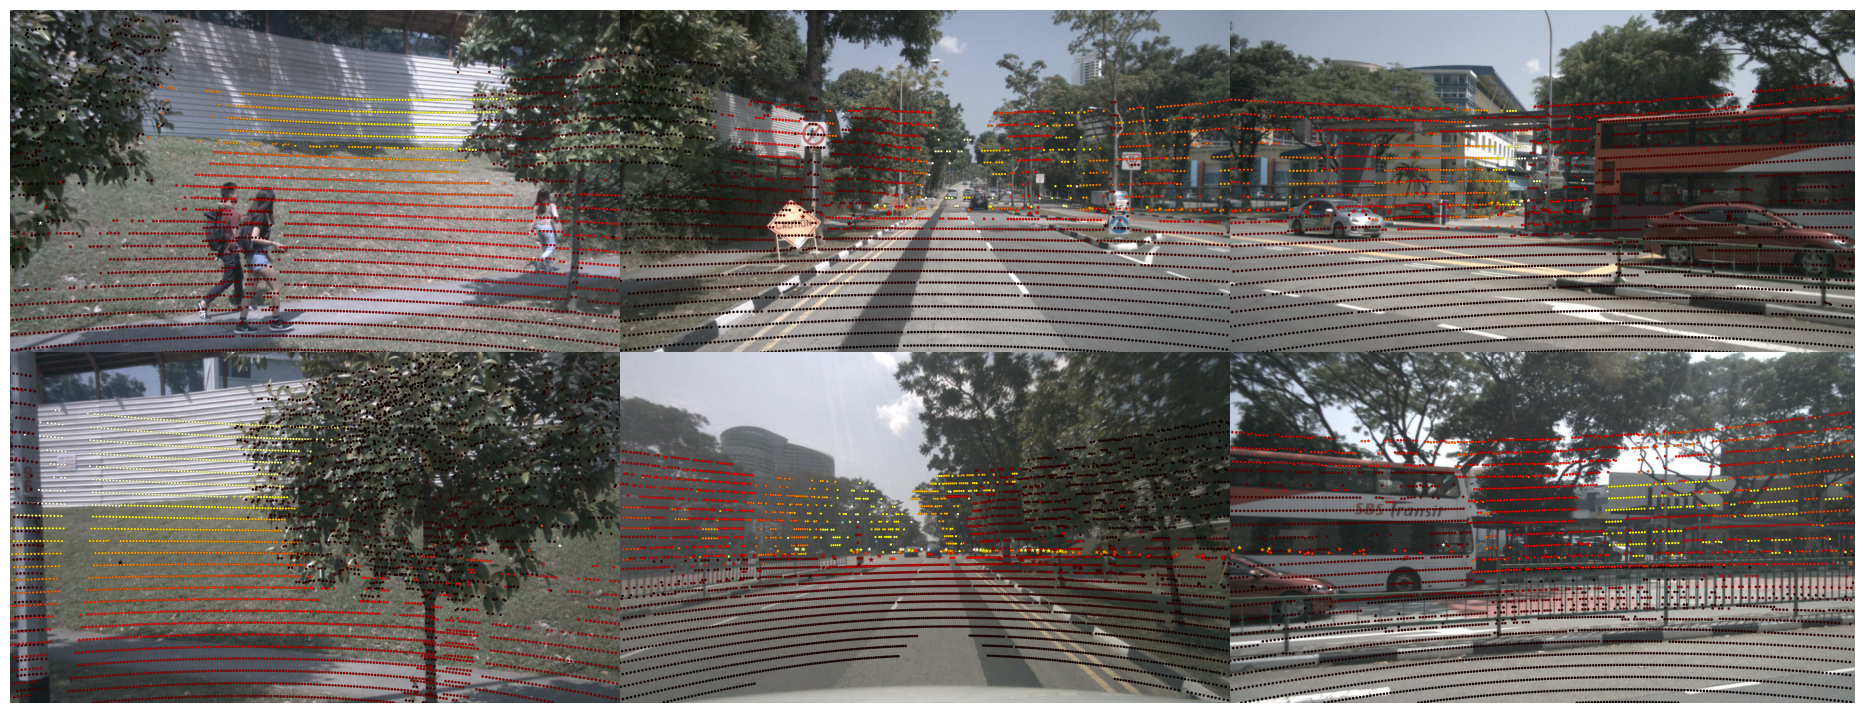

In [123]:
nusc.render_pointcloud_in_scene(nusc.sample[index]['token'], nsweeps = nsweeps, show_both_modality=True, verbose=True)

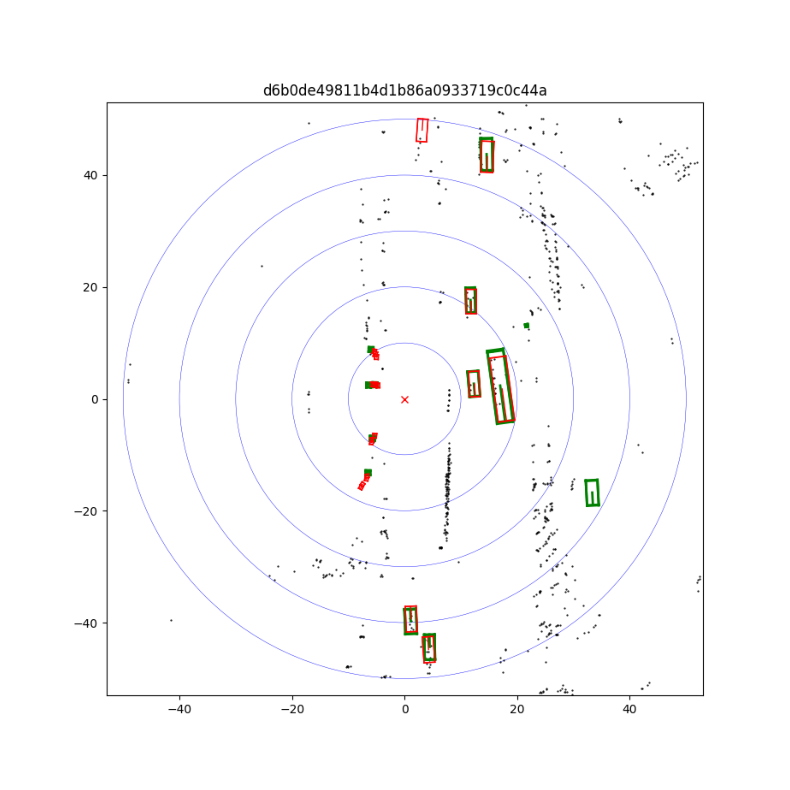

In [126]:
image_name = str(nusc.get('sample',nusc.sample[index]['token'])['timestamp'])+'.png'

pred_result = plt.imread(osp.join('/home/byounghun/workspace/CRN/outputs/det/CRN_r18_256x704_128x128_4key/examples',image_name))
plt.figure(figsize=(10, 10))
plt.imshow(pred_result)
plt.axis('off')
plt.show()

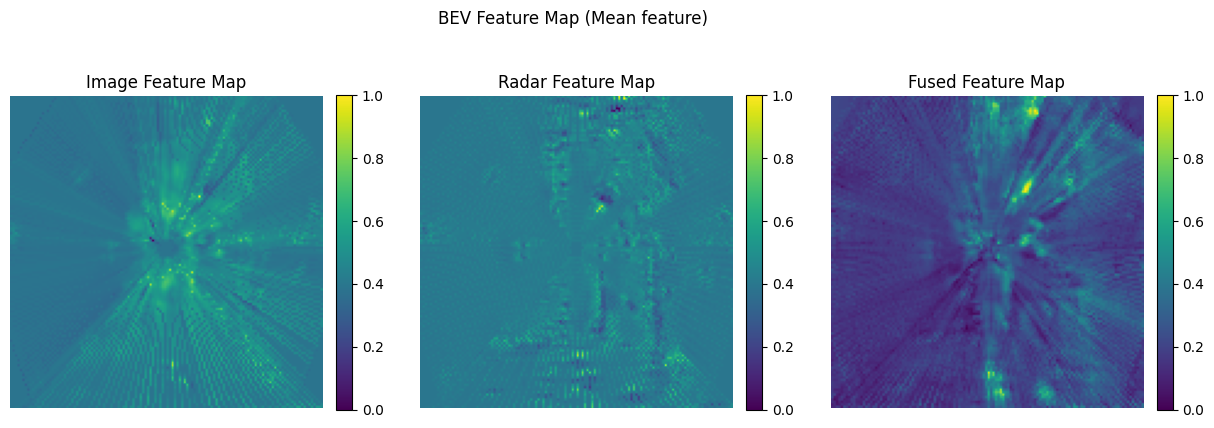

In [125]:
# 모든 feature channel에서 평균값을 취하여 2D BEV map 생성
image_feature_map_max = np.mean(image_feature_map[0, :, :, :], axis=0)
image_feature_map_max_normalized = (image_feature_map_max - np.min(image_feature_map_max)) / (np.max(image_feature_map_max) - np.min(image_feature_map_max))
image_rotated_map = np.rot90(image_feature_map_max_normalized, k=1)
image_mirrored_map = image_rotated_map[:, ::-1]

radar_feature_map_max = np.mean(radar_feature_map[0, :, :, :], axis=0)
radar_feature_map_max_normalized = (radar_feature_map_max - np.min(radar_feature_map_max)) / (np.max(radar_feature_map_max) - np.min(radar_feature_map_max))
radar_rotated_map = np.rot90(radar_feature_map_max_normalized, k=1)
radar_mirroed_map = radar_rotated_map[:, ::-1]

fused_feature_map_max = np.mean(fused_feature_map[0, :, :, :], axis=0)
fused_feature_map_max_normalized = (fused_feature_map_max - np.min(fused_feature_map_max)) / (np.max(fused_feature_map_max) - np.min(fused_feature_map_max))
fused_rotated_map = np.rot90(fused_feature_map_max_normalized, k=1)
fused_mirrored_map = fused_rotated_map[:, ::-1]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

im0 = axes[0].imshow(image_mirrored_map, cmap='viridis')
axes[0].set_title('Image Feature Map')
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(radar_mirroed_map, cmap='viridis')
axes[1].set_title('Radar Feature Map')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(fused_mirrored_map, cmap='viridis')
axes[2].set_title('Fused Feature Map')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.suptitle('BEV Feature Map (Mean feature)')
plt.show()